# Optimization and Algorithms Project - Task 11

## Group Members
*David Marafuz Gaspar* | 106541  
*Pedro Gaspar Mónico* | 106626  
*Francisco Palma* | 105949  
*Pedro Salazar Leite* | 106812  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Auxiliary Function to construct matrix A and vector b
def construct_A_b(points):
    N = len(points)
    A = np.ones((N, 3))
    b = np.zeros(N)
    
    for i in range(N):
        x, y = points[i]
        A[i, 1] = -2 * x
        A[i, 2] = -2 * y
        b[i] = -(x**2 + y**2)
    
    return A, b

# Auxiliary Function to Compute LS solution
def compute_ls_solution(points):
    A, b = construct_A_b(points)
    solution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    return solution 
    
# Auxiliary Function to Update for agent p in BCD iteration
def agent_update(A_p, b_p, u_0, lambda_p, c):
    # u_p = (A_p^T A_p + (c/2)I)^(-1) * (A_p^T b_p + (c/2)u_0 + (1/2)lambda_p)
    n_vars = A_p.shape[1]
    lhs = A_p.T @ A_p + (c/2) * np.eye(n_vars)
    rhs = A_p.T @ b_p + (c/2) * u_0 + (1/2) * lambda_p
    u_p = np.linalg.solve(lhs, rhs)
    return u_p

# Auxiliary Function to Update for server in BCD iteration
def server_update(u_ps, lambdas, c):
    # u_0 = (1/P) * sum(u_p) - (1/(cP)) * sum(lambda_p)
    P = len(u_ps)
    sum_u_p = np.sum(u_ps, axis=0)
    sum_lambda = np.sum(lambdas, axis=0)
    u_0 = (1/P) * sum_u_p - (1/(c * P)) * sum_lambda
    return u_0

In [3]:
# Circle fitting using ALM and BCD
def distributed_circle_fitting(agent_data_files, c, epsilon_alm, epsilon_bcd, max_alm_iters, max_bcd_iters):

    P = len(agent_data_files)
    agent_data = []
    A_ps = []
    b_ps = []
    ls_solutions = []

    for i, file in enumerate(agent_data_files):
        data = np.load(file)
        data = data.T
        agent_data.append(data)
        A_p, b_p = construct_A_b(data)
        A_ps.append(A_p)
        b_ps.append(b_p)

        # Compute LS solution for this agent
        ls_sol = compute_ls_solution(data)
        ls_solutions.append(ls_sol)

        y_star, c_x, c_y = ls_sol
        R_ls = np.sqrt(c_x**2 + c_y**2 - y_star)
        print(f"Agent {i+1}: {len(data)} points, LS center=({c_x:.2f}, {c_y:.2f}), radius={R_ls:.2f}")


    lambda_ps = [np.zeros(3) for _ in range(P)]  # Lagrange multipliers

    # Initialize local variables with each agent's LS solution
    x_ps = [ls_solutions[p].copy() for p in range(P)]

    x_0 = np.zeros(3)

    max_constraint_violations = []
    bcd_iterations_per_alm = []

    # ALM iterations
    for alm_iter in range(max_alm_iters):
        print(f"\nALM Iteration {alm_iter + 1}")

        # BCD to solve the ALM subproblem
        u_0 = x_0.copy()
        bcd_converged = False

        for bcd_iter in range(max_bcd_iters):
            u_0_old = u_0.copy()

            # Agents update their local variables
            u_ps = []
            for p in range(P):
                u_p = agent_update(A_ps[p], b_ps[p], u_0, lambda_ps[p], c)
                u_ps.append(u_p)

            u_0 = server_update(u_ps, lambda_ps, c)

            # Check BCD convergence
            bcd_error = np.linalg.norm(u_0 - u_0_old)
            if bcd_error < epsilon_bcd:
                bcd_converged = True
                break

        if not bcd_converged:
            print(f"BCD did not converge after {max_bcd_iters} iterations")

        bcd_iterations_per_alm.append(bcd_iter + 1)
        print(f"BCD iterations: {bcd_iter + 1}")

        # Update variables after BCD convergence
        x_0 = u_0.copy()
        for p in range(P):
            x_ps[p] = u_ps[p].copy()

        # Update Lagrange multipliers
        max_violation = 0
        for p in range(P):
            constraint_violation = x_0 - x_ps[p]
            lambda_ps[p] = lambda_ps[p] + c * constraint_violation
            # Calculate relative violation: ‖x_0^k - x_p^k‖₂ / ‖x_0^k‖₂
            violation_norm = np.linalg.norm(constraint_violation)
            relative_violation = violation_norm / (np.linalg.norm(x_0))
            max_violation = max(max_violation, relative_violation)

        max_constraint_violations.append(max_violation)
        print(f"Max constraint violation: {max_violation:.6f}")

        if max_violation < epsilon_alm:
            print(f"ALM converged after {alm_iter + 1} iterations!")
            break

    # Extract circle parameters from final solution
    y_star = x_0[0]
    c_x = x_0[1]
    c_y = x_0[2]
    R = np.sqrt(c_x**2 + c_y**2 - y_star)

    results = {
        'center': (c_x, c_y),
        'radius': R,
        'max_constraint_violations': max_constraint_violations,
        'bcd_iterations_per_alm': bcd_iterations_per_alm,
        'final_alm_iter': alm_iter + 1,
        'global_variable': x_0
    }

    return results, agent_data, ls_solutions



Agent 1: 10 points, LS center=(2.97, 7.49), radius=1.91
Agent 2: 10 points, LS center=(-1.76, 7.09), radius=1.54
Agent 3: 10 points, LS center=(-1.93, 3.34), radius=1.38
Agent 4: 10 points, LS center=(2.67, 2.70), radius=1.97

ALM Iteration 1
BCD iterations: 170
Max constraint violation: 0.059167

ALM Iteration 2
BCD iterations: 3
Max constraint violation: 0.020713

ALM Iteration 3
BCD iterations: 3
Max constraint violation: 0.010102

ALM Iteration 4
BCD iterations: 2
Max constraint violation: 0.007690
ALM converged after 4 iterations!


Center: (1.2214, 5.0494)
Radius: 4.0836
ALM iterations: 4
BCD iterations per ALM iteration: [170, 3, 3, 2]

Centralized LS result:
Center: (1.2029, 5.1222)
Radius: 4.1085


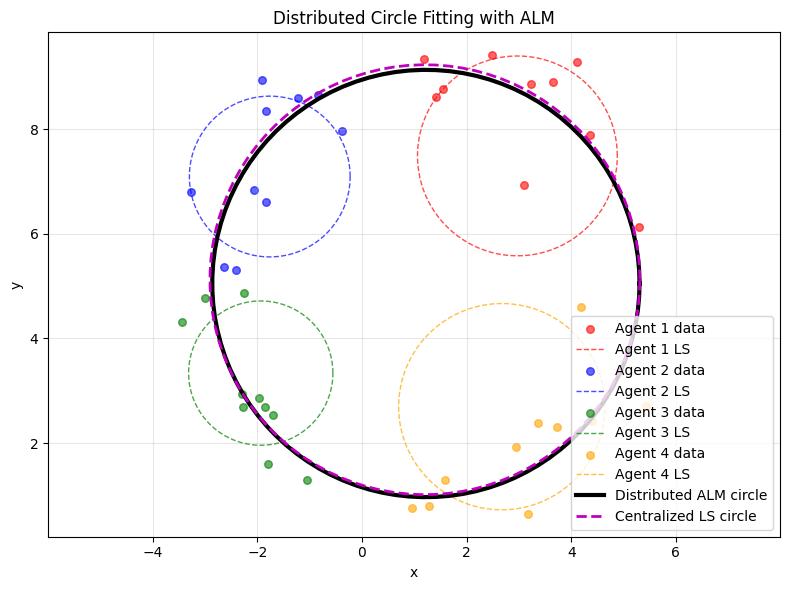

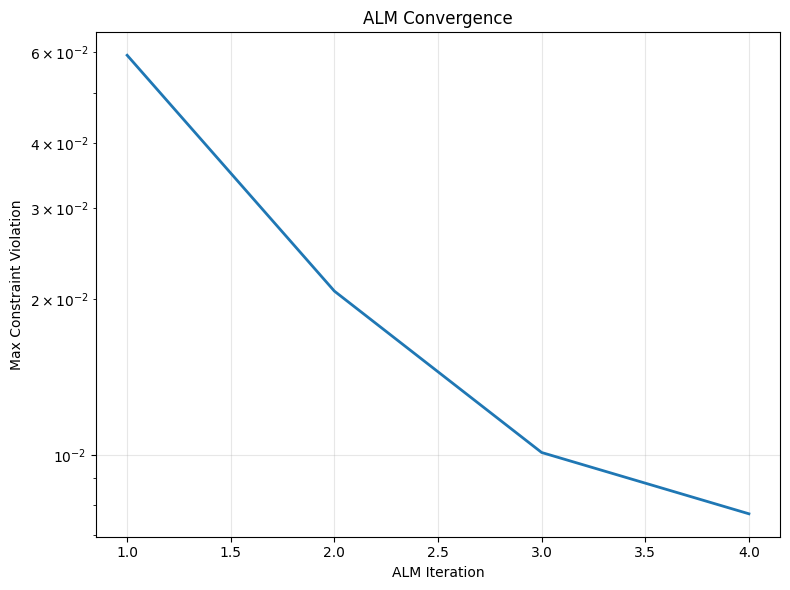

In [4]:
agent_files = [
    'Data/dataset1.npy',
    'Data/dataset2.npy',
    'Data/dataset3.npy',
    'Data/dataset4.npy'
]

results, agent_data, ls_solutions = distributed_circle_fitting(
    agent_files,
    c=100,
    epsilon_alm=0.01,
    epsilon_bcd=0.01,
    max_alm_iters=200,
    max_bcd_iters=200
)

c_x, c_y = results['center']
R = results['radius']
print(f"\n")
print(f"Center: ({c_x:.4f}, {c_y:.4f})")
print(f"Radius: {R:.4f}")
print(f"ALM iterations: {results['final_alm_iter']}")
print(f"BCD iterations per ALM iteration: {results['bcd_iterations_per_alm']}")

all_points = np.vstack(agent_data)
x = all_points[:, 0]
y = all_points[:, 1]
A = np.column_stack((2*x, 2*y, np.ones_like(x)))
b = x**2 + y**2
z, *_ = np.linalg.lstsq(A, b, rcond=None)
a_central, b_central, c_central = z
R_central = np.sqrt(a_central**2 + b_central**2 + c_central)

print(f"\nCentralized LS result:")
print(f"Center: ({a_central:.4f}, {b_central:.4f})")
print(f"Radius: {R_central:.4f}")

colors = ['red', 'blue', 'green', 'orange']

fig1, ax1 = plt.subplots(figsize=(8, 6))

for i, data in enumerate(agent_data):
    ax1.scatter(data[:, 0], data[:, 1], color=colors[i], alpha=0.6,
                label=f'Agent {i+1} data', s=30)

    if i < len(ls_solutions):
        y_star, ls_c_x, ls_c_y = ls_solutions[i]
        ls_R = np.sqrt(ls_c_x**2 + ls_c_y**2 - y_star)
        theta = np.linspace(0, 2*np.pi, 100)
        circle_x = ls_c_x + ls_R * np.cos(theta)
        circle_y = ls_c_y + ls_R * np.sin(theta)
        ax1.plot(circle_x, circle_y, color=colors[i], linestyle='--',
                 linewidth=1, alpha=0.7, label=f'Agent {i+1} LS')

theta = np.linspace(0, 2*np.pi, 100)
circle_x = c_x + R * np.cos(theta)
circle_y = c_y + R * np.sin(theta)
ax1.plot(circle_x, circle_y, 'black', linewidth=3, label='Distributed ALM circle')

circle_x_central = a_central + R_central * np.cos(theta)
circle_y_central = b_central + R_central * np.sin(theta)
ax1.plot(circle_x_central, circle_y_central, 'm--', linewidth=2, label='Centralized LS circle')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Distributed Circle Fitting with ALM')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(8, 6))

ax2.semilogy(range(1, len(results['max_constraint_violations']) + 1),
             results['max_constraint_violations'], linewidth=2)
ax2.set_xlabel('ALM Iteration')
ax2.set_ylabel('Max Constraint Violation')
ax2.set_title('ALM Convergence')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()